<a href="https://colab.research.google.com/github/GrzegorzSzczepanek/deep_learning_fun/blob/main/KMIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [111]:
train_data = datasets.KMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.KMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

image, label = train_data[0]
# image, label

In [112]:
image.shape

torch.Size([1, 28, 28])

In [113]:
class_names = train_data.classes
class_names

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

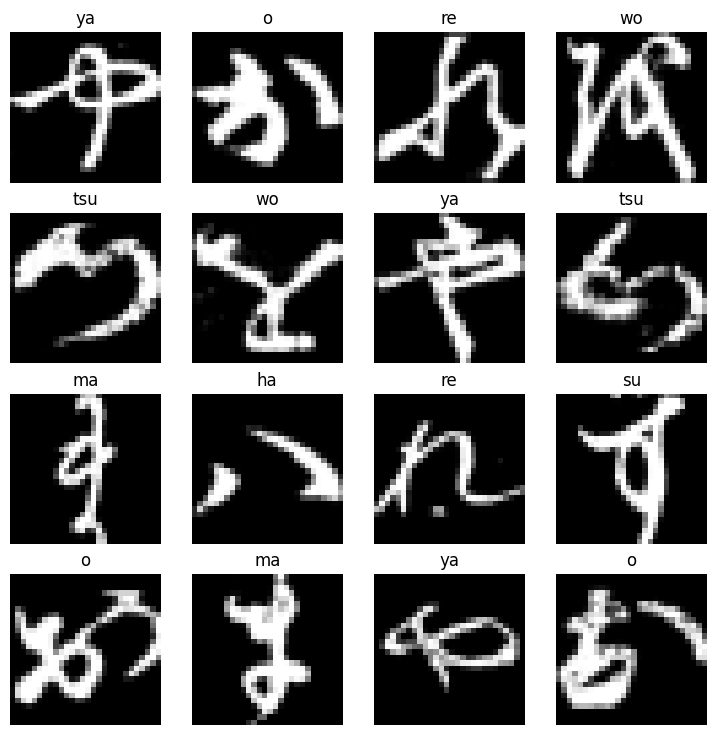

In [114]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [115]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [116]:
class MNIST_Model(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
      super().__init__()
      self.block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )
      self.block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*7*7,
                    out_features=output_shape)
      )

  def forward(self, x):
    return self.classifier(self.block_2(self.block_1(x)))

model = MNIST_Model(1, 10, len(class_names)).to(device)
model

MNIST_Model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [117]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [118]:
from helper_functions import accuracy_fn
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

epochs = 3

In [119]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device = device):
  train_loss, train_acc = 0, 0
  model.train()
  model.to(device)
  for batch, (X,y) in enumerate(data_loader):
    #print(X.shape)
    X, y= X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)
      )

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [120]:
def train(model: torch.nn.Module,
          train_data_loader: torch.utils.data.DataLoader,
          test_data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          epochs: int,
          device:torch.device = device):

  from timeit import default_timer as timer
  from tqdm.auto import tqdm
  train_time_start = timer()

  for epoch in tqdm(range(epochs)):
    if epoch % 200:
      print(f"Epochs: {epoch}\n-----------------------")

    train_step(model=model,
               data_loader=train_data_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    test_step(model=model,
              data_loader=test_data_loader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  train_time_end = timer()
  print(f"{(train_time_end - train_time_start):.3f}")

In [121]:
train(model=model,
      train_data_loader=train_dataloader,
      test_data_loader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      epochs=epochs)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.79675 | Train accuracy: 35.32%
Test loss: 0.99569 | Test accuracy: 68.16%

Epochs: 1
-----------------------
Train loss: 0.43134 | Train accuracy: 86.73%
Test loss: 0.63384 | Test accuracy: 80.06%

Epochs: 2
-----------------------
Train loss: 0.27522 | Train accuracy: 91.74%
Test loss: 0.55315 | Test accuracy: 82.74%

35.166


In [122]:
# device = "cpu"
# train(model=model,
#       train_data_loader=train_dataloader,
#       test_data_loader=test_dataloader,
#       loss_fn=loss_fn,
#       optimizer=optimizer,
#       accuracy_fn=accuracy_fn,
#       epochs=epochs,
#       device="cpu")

In [125]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            print(sample.device)

            print(data[0].device)
            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [126]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 8 (re)


In [127]:
pred_probs= make_predictions(model=model,
                             data=test_samples)

pred_probs[:2]

cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu


tensor([[5.0245e-04, 1.6712e-01, 1.8405e-02, 2.5677e-02, 2.0651e-03, 4.3761e-03,
         1.3046e-03, 7.6201e-03, 7.7261e-01, 3.1381e-04],
        [4.1925e-05, 2.9826e-03, 4.0988e-01, 2.0153e-03, 7.2479e-05, 2.6380e-04,
         1.0473e-04, 7.7658e-03, 2.7936e-03, 5.7408e-01]])

In [128]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 9, 3, 1, 1, 4, 6, 3, 7])

In [129]:
test_labels, pred_classes

([8, 9, 3, 9, 1, 4, 6, 3, 3], tensor([8, 9, 3, 1, 1, 4, 6, 3, 7]))

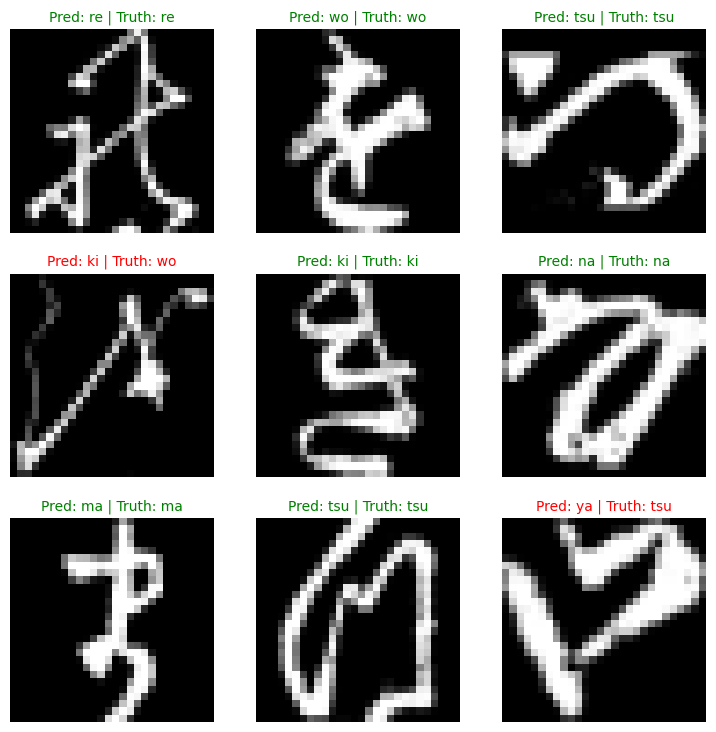

In [131]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):

  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);